# Useful Imports

In [1]:
from KernelFlow import KernelFlowsCNNGP
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import numpy as np
from utils import get_accuracy
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision.transforms as T
from torch import nn
import psutil
import time
from cnn_gp import Sequential, Conv2d, ReLU, resnet_block
from tqdm import tqdm
from scipy.linalg import lstsq
from sklearn.metrics import accuracy_score
%load_ext autoreload
%autoreload 2

c:\Users\walee\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Global parameters

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                T.Lambda(lambda x: torch.flatten(x)),
                                T.Lambda(lambda x: nn.functional.normalize(x, p=2, dim=0)),
                                T.Lambda(lambda x: torch.reshape(x, (28,28))),
                                T.Lambda(lambda x: torch.unsqueeze(x, dim=0))
                              ])

# transform = transforms.Compose([transforms.ToTensor()])

batch_size = 50000
val_size = 1000
N_I = 1000

# MNIST
trainset = datasets.MNIST('MNIST_dataset/train', download=True, train=True, transform=transform)
valset = datasets.MNIST('MNIST_dataset/val', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=val_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataiter = iter(trainloader)
X_train, Y_train = dataiter.next()
X_train = X_train.to(device)
Y_train = Y_train.to(device)
Y_train = F.one_hot(Y_train, 10).to(torch.float32)

dataiter_val = iter(valloader)
X_test, Y_test = dataiter_val.next()
X_test = X_test.to(device)
Y_test = Y_test.to(device)

# Model

In [4]:
model_untrained = Sequential(
        Conv2d(kernel_size=3),
        ReLU(),
        Conv2d(kernel_size=3, stride=2),
        ReLU(),
        Conv2d(kernel_size=14, padding=0),  # equivalent to a dense layer
        )

model_untrained.to(device)

# var_bias = 7.86
# var_weight = 2.79

# layers = []
# for _ in range(7):  # n_layers
#     layers += [
#         Conv2d(kernel_size=7, padding="same", var_weight=var_weight * 7**2,
#                var_bias=var_bias),
#         ReLU(),
#     ]
# covnet = Sequential(
#     *layers,
#     Conv2d(kernel_size=28, padding=0, var_weight=var_weight,
#            var_bias=var_bias),
# )

# covnet.to(device)

Sequential(
  (0): Conv2d()
  (1): ReLU()
  (2): Conv2d()
  (3): ReLU()
  (4): Conv2d()
)

In [6]:
start_usage = psutil.virtual_memory()
with torch.no_grad():
# covnet_result = covnet(X_train[:200], X_train[:200])
    covnet_result = model_untrained(X_train[:400], X_train[:400])
end_usage = psutil.virtual_memory()
print((end_usage.used - start_usage.used) / 1e9)
del covnet_result

-0.266215424


# Memory usage vs Amount of input data

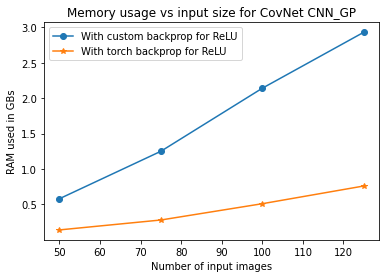

In [22]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(50, 150, 25), [0.58,1.25,2.14,2.93], '-o', label='With custom backprop for ReLU')
ax.plot(np.arange(50, 150, 25), [0.14,0.28,0.51,0.76], '-*', label='With torch backprop for ReLU')
ax.set_xlabel("Number of input images")
ax.set_ylabel("RAM used in GBs")
ax.set_title("Memory usage vs input size for CovNet CNN_GP")
plt.legend()
fig.savefig("figs/RAM_usage_ReLU_backprop.png")

# Pretraining Results

In [5]:
Y_pred_untrained, k, t= KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train=X_train[:250], Y_train=Y_train[:250], kernel=model_untrained, regularization_lambda=0.0001, blocksize=250)
Y_pred_untrained = np.argmax(Y_pred_untrained.cpu(), axis=1)
print(f"""Accuracy with 250 training points on untrained convnet was {accuracy_score(Y_pred_untrained, Y_test.cpu().numpy()) * 100}""")

Accuracy with 250 training points on untrained convnet was 74.7


In [22]:
Y_pred_untrained_blocked = KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train = X_train[:125], Y_train = Y_train[:125].to(torch.float32), kernel = model_untrained, blocksize=100)
Y_pred_untrained_blocked = np.argmax(Y_pred_untrained_blocked, axis=1)
accuracy_untrained_blocked = get_accuracy(Y_pred_untrained_blocked, Y_test.detach().numpy())
print("The accuracy with training was: ", accuracy_untrained_blocked)

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


The accuracy with training was:  68.0


# Training the model

In [4]:
model_trained = Sequential(
        Conv2d(kernel_size=3),
        ReLU(),
        Conv2d(kernel_size=3, stride=2),
        ReLU(),
        Conv2d(kernel_size=14, padding=0),  # equivalent to a dense layer
        )

model_trained.to(device)
# var_bias = 7.86
# var_weight = 2.79

# layers = []
# for _ in range(7):  # n_layers
#     layers += [
#         Conv2d(kernel_size=7, padding="same", var_weight=var_weight * 7**2,
#                var_bias=var_bias),
#         ReLU(),
#     ]

# covnet_trained = Sequential(
#     *layers,
#     Conv2d(kernel_size=28, padding=0, var_weight=var_weight,
#            var_bias=var_bias),
# )
# We already have a saved model
# model_trained.load_state_dict(torch.load('models/simple_1000_iter.pth'))

Sequential(
  (0): Conv2d()
  (1): ReLU()
  (2): Conv2d()
  (3): ReLU()
  (4): Conv2d()
)

In [10]:
KFCNNGP = KernelFlowsCNNGP(cnn_gp_kernel=model_trained)
KFCNNGP.fit(X_train, Y_train, 10, 10)

100%|██████████| 10/10 [00:00<00:00, 34.25it/s]


(0.0, 1.0)

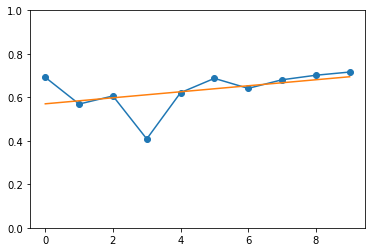

In [11]:
plt.plot(KFCNNGP.rho_values, '-o')
m, b = np.polyfit(np.arange(0, len(KFCNNGP.rho_values)), KFCNNGP.rho_values, 1)
plt.plot(np.arange(0, len(KFCNNGP.rho_values)), m*np.arange(0, len(KFCNNGP.rho_values)) + b)
plt.ylim((0,1))

In [12]:
for param in model_trained.parameters():
    print(param)
Y_pred_trained, k, t= KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train=X_train[:250], Y_train=Y_train[:250], kernel=model_trained, regularization_lambda=0.0001, blocksize=250)
Y_pred_trained = np.argmax(Y_pred_trained.cpu(), axis=1)
print(f"""Accuracy with 250 training points on trained convnet was {accuracy_score(Y_pred_trained, Y_test.cpu().numpy()) * 100}""")

Parameter containing:
tensor([964.4337], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([34.9294], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-1491.9237], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([63.4249], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([10.0412], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([64.5977], device='cuda:0', requires_grad=True)
Accuracy with 250 training points on trained convnet was 25.2


# Plotting Accuracy vs $N_I$

In [11]:
N_i_arr = np.arange(50, 500, 50)
untrained_accuracy_list = []
trained_accuracy_list = []
    
for ni in tqdm(N_i_arr):
    X_train_batch = X_train[:ni]
    Y_train_batch = Y_train[:ni]
    Y_pred_untrained = KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train = X_train_batch, Y_train = Y_train_batch.to(torch.float32), kernel = model_untrained, blocksize=50)
    Y_pred_untrained = np.argmax(Y_pred_untrained, axis=1)
    untrained_accuracy_list.append(get_accuracy(Y_pred_untrained, Y_test.detach().numpy()))
    Y_pred_trained = KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train = X_train_batch, Y_train = Y_train_batch.to(torch.float32), kernel = model_trained, blocksize=50)
    Y_pred_trained = np.argmax(Y_pred_trained, axis=1)
    trained_accuracy_list.append(get_accuracy(Y_pred_trained, Y_test.detach().numpy()))

100%|██████████| 9/9 [04:59<00:00, 33.24s/it]


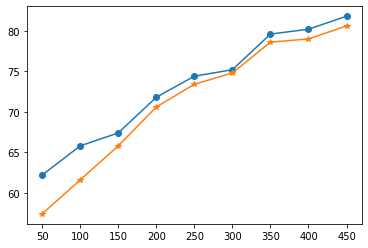

In [12]:
plt.plot(N_i_arr, untrained_accuracy_list, '-o')
plt.plot(N_i_arr, trained_accuracy_list, '-*')

In [ ]:
Y_pred_untrained_blocked = KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train = X_train[:1000], Y_train = Y_train[:1000].to(torch.float32), kernel = model_untrained, blocksize=100)
Y_pred_untrained_blocked = np.argmax(Y_pred_untrained_blocked, axis=1)
accuracy_untrained_blocked = get_accuracy(Y_pred_untrained_blocked, Y_test.detach().numpy())
print("The accuracy with training was: ", accuracy_untrained_blocked)